In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import io
import pykilosort as ks
from pykilosort import datashift

import matplotlib.pyplot as plt

In [3]:
matlab_input = io.loadmat("/home/alexmorley/git_repos/standalonedetector_input.mat",
                          struct_as_record=False)

#for k in matlab_input.keys():
#    if k.startswith("_"):
#        continue
#print(f"{k} = matlab_input[\"{k}\"]")

rez = matlab_input["rez"]
NrankPC = matlab_input["NrankPC"]
wPCA = matlab_input["wPCA_"]
wTEMP = matlab_input["wTEMP_"]
yup = matlab_input["yup"]
xup = matlab_input["xup"]
Nbatch = matlab_input["Nbatch"]

In [4]:
matlab_output = io.loadmat("/home/alexmorley/git_repos/standalonedetector_output.mat")

expected_st3 = matlab_output["st3"]

In [5]:
# bit of data muching to get things in the same format with new params/probe stype

rez_dict = {f: getattr(rez[0][0], f) for f in rez[0][0]._fieldnames}
rez_dict["ops"] = {f: getattr(rez_dict["ops"][0][0], f) for f in rez_dict["ops"][0][0]._fieldnames}
xc = np.array(rez_dict["xc"].flat)
yc = np.array(rez_dict["yc"].flat)
Nchan = rez_dict["ops"]["Nchan"]
Nbatch = rez_dict["ops"]["Nbatch"][0][0]

probe = ks.params.Probe(xc=xc, yc=yc, Nchan=Nchan, NchanTOT=Nchan,
                chanMap=np.array([]), kcoords=np.array([]))

rez_dict["ops"]["Th"] = list(rez_dict["ops"]["Th"][0])
rez_dict["ops"]["momentum"] = list(rez_dict["ops"]["momentum"][0])

params = ks.params.KilosortParams(**rez_dict["ops"], probe=probe);

In [7]:
proc_path = rez_dict['ops']['fproc'][0]
proc = np.memmap(proc_path, dtype=np.int16, mode="r", order="F")

In [8]:
# run the CUDA function on this batch
st3 = datashift.standalonedetector.standalone_detector(
    wTEMP, wPCA, NrankPC, yup, xup, Nbatch, proc, probe, params
)

Detecting Spikes: 100%|███████████████████████████████████| 46/46 [12:43<00:00, 16.59s/it]

763.190402507782 sec, 46 batches, 28237 spikes


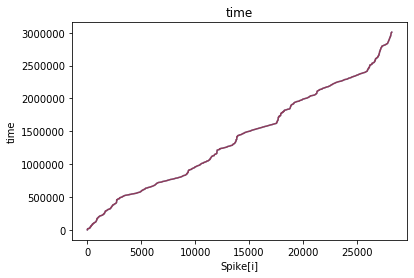

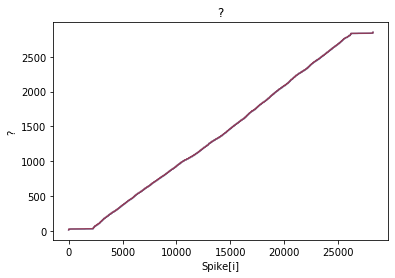

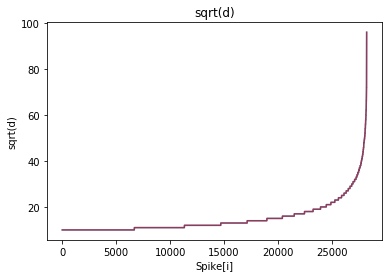

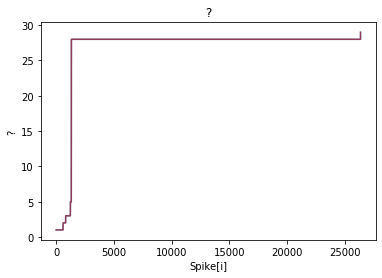

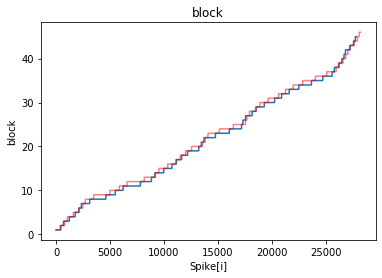

In [12]:
for i,nm in enumerate(["time", "?", "sqrt(d)", "?", "block"]):
    plt.figure()

    plt.plot(np.sort(st3[:,i])[np.sort(st3[:,i])>0])

    plt.plot(np.sort(expected_st3[:,i])[np.sort(expected_st3[:,i])>0], color="r", alpha=0.5)
    
    plt.ylabel(nm)
    plt.title(nm)
    plt.xlabel("Spike[i]")